# Multi-Agent System with LangGraph

In [ ]:
!pip install langchain langchain-google-genai langchain_community langgraph langchain_experimental langgraph-supervisor

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 32.2 MB/s eta 0:00:00
  Attempting uninstall: google-ai-generativelanguage
    Found existing installation: google-ai-generativelanguage 0.6.15
    Uninstalling google-ai-generativelanguage-0.6.15:
      Successfully uninstalled google-ai-generativelanguage-0.6.15
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-generativeai 0.8.5 requires google-ai-generativelanguage==0.6.15, but you have google-ai-generativelanguage 0.6.18 which is incompatible.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.2/209.2 kB 6.3 MB/s eta 0:00:00


## Define a LLM model

In [ ]:
import os
from google.colab import userdata
from langchain.chat_models import init_chat_model

os.environ['GOOGLE_API_KEY'] = userdata.get('Gemini_API_key')
llm = init_chat_model("google_genai:gemini-2.0-flash-lite")

## Define Agents

### SQL agent

#### Set up the database

In [ ]:
import requests

url = "https://storage.googleapis.com/benchmarks-artifacts/chinook/Chinook.db"

response = requests.get(url)

if response.status_code == 200:
    with open("Chinook.db", "wb") as file:
        file.write(response.content)
    print("File downloaded and saved as Chinook.db")
else:
    print(f"Failed to download the file. Status code: {response.status_code}")

File downloaded and saved as Chinook.db


In [ ]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///Chinook.db")

# check the data
print(f"Dialect: {db.dialect}")
print(f"Available tables: {db.get_usable_table_names()}")
print(f'Sample output: {db.run("SELECT * FROM Artist LIMIT 5;")}')

Dialect: sqlite
Available tables: ['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']
Sample output: [(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains')]


#### register tools for database interactions

In [ ]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit

toolkit = SQLDatabaseToolkit(db=db, llm=llm)

tools = toolkit.get_tools()

for tool in tools:
    print(f"{tool.name}: {tool.description}\n")

sql_db_query: Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.

sql_db_schema: Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3

sql_db_list_tables: Input is an empty string, output is a comma-separated list of tables in the database.

sql_db_query_checker: Use this tool to double check if your query is correct before executing it. Always use this tool before executing a query with sql_db_query!



In [ ]:
from langgraph.prebuilt import create_react_agent

sql_prompt = """
You are an agent designed to perform reasoning and computations using Python, based on structured data fetched from a SQL database.

You operate on the output of a prior SQL query. Your role is to help answer the user's original question by applying logic, analysis, or transformations to that SQL result.

Always follow these steps:

1. Carefully review the user's original question and the query result from the SQL agent.
2. Identify what additional computation is required to complete the answer. This might include:
   - Aggregations (sum, average, max, etc.)
   - Calculations (differences, ratios, growth rates)
   - Filtering or grouping
   - Trend detection or simple statistical logic
3. Use Python tools to perform this computation.
4. Return a final, natural-language answer to the user, backed by the result of your analysis.
5. Please display the generated Python script explicitly in your response, prefixed with "PYTHON_SCRIPT:". # 変更点: プレフィックスの追加と表示形式の明確化

Guidelines:

- Do NOT attempt to access or modify the SQL database yourself.
- Do NOT re-query data. Your role is to reason only over the existing SQL result.
- If the data provided is insufficient to compute an answer, clearly state what is missing and why.
- Be precise and clear in your computations.
- If the output is numeric, include meaningful context (units, columns, comparison).
- If the result involves uncertainty or approximation, state assumptions clearly.

Examples of tasks you should perform:
- “Calculate the revenue growth rate between two quarters.”
- “Find the genre with the highest average sales.”
- “Determine if one category consistently outperforms another over time.”

Focus on thoughtful, transparent reasoning based on provided data.
""".format(
    dialect=db.dialect,
    top_k=5,
)

sql_agent = create_react_agent(
    llm,
    tools,
    prompt=sql_prompt,
    name = 'SQL_agent'
)

#### Test the sql agent

In [ ]:
question = "Which genre on average has the longest tracks?"

for step in sql_agent.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Which genre on average has the longest tracks?
================================== Ai Message ==================================
Name: SQL_agent

Okay, I need to find out which genre has the longest tracks on average.

First, let's see the available tables.
Tool Calls:
  sql_db_list_tables (e317b96e-04f3-4f39-9d9a-f4adef1da299)
 Call ID: e317b96e-04f3-4f39-9d9a-f4adef1da299
  Args:
================================= Tool Message =================================
Name: sql_db_list_tables

Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track
================================== Ai Message ==================================
Name: SQL_agent
Tool Calls:
  sql_db_schema (0f366f4a-0734-4ab2-9cfa-750648dd5eda)
 Call ID: 0f366f4a-0734-4ab2-9cfa-750648dd5eda
  Args:
    table_names: Genre,Track
================================= Tool Message ==========================

### Python agent

In [ ]:
from langchain_core.tools import tool
from langchain_experimental.tools.python.tool import PythonREPLTool

python_obj = PythonREPLTool()

python_prompt = python_agent_prompt = """
You are an agent designed to perform reasoning and computations using Python, based on structured data fetched from a SQL database.

You operate on the output of a prior SQL query. Your role is to help answer the user's original question by applying logic, analysis, or transformations to that SQL result.

Always follow these steps:

1. Carefully review the user's original question and the query result from the SQL agent.
2. Identify what additional computation is required to complete the answer. This might include:
   - Aggregations (sum, average, max, etc.)
   - Calculations (differences, ratios, growth rates)
   - Filtering or grouping
   - Trend detection or simple statistical logic
3. Use Python tools to perform this computation.
4. Return a final, natural-language answer to the user, backed by the result of your analysis.
5. Please display the generated Python script explicitly in your response.

Guidelines:

- Do NOT attempt to access or modify the SQL database yourself.
- Do NOT re-query data. Your role is to reason only over the existing SQL result.
- If the data provided is insufficient to compute an answer, clearly state what is missing and why.
- Be precise and clear in your computations.
- If the output is numeric, include meaningful context (units, columns, comparison).
- If the result involves uncertainty or approximation, state assumptions clearly.

Examples of tasks you should perform:
- “Calculate the revenue growth rate between two quarters.”
- “Find the genre with the highest average sales.”
- “Determine if one category consistently outperforms another over time.”

Focus on thoughtful, transparent reasoning based on provided data.
"""

python_agent = create_react_agent(
    model = llm,
    tools = [python_obj],
    prompt = python_prompt,
    name = 'Python_agent'
)


## Define a supervisor with `create_supervisor`

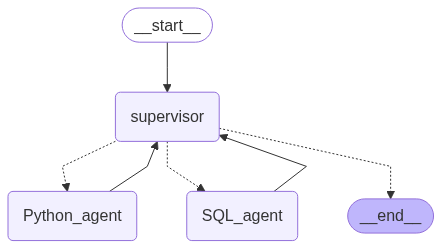

In [ ]:
from langgraph_supervisor import create_supervisor
from IPython.display import Image, display

supervisor_prompt = """
You are a supervisor agent responsible for coordinating a system that answers user questions by interacting with two specialized agents:

1. SQL_agent — Retrieves structured data from a SQL database by generating and executing SQL queries.
2. Python_agent — Performs computation or reasoning over the data returned by the SQL_agent.

Your goal is to ensure that the user's question is answered accurately by invoking these agents in the correct sequence.

Always follow these steps:

1. Begin by passing the user’s question to the SQL_agent.
   - The SQL_agent will examine the database schema and formulate a SQL query.
   - It will then return either:
     a. A direct answer, based on the query result, **or**
     b. A message stating that **further computation is needed**, along with the raw query result.

2. If the SQL_agent indicates that additional reasoning or processing is needed:
   - Forward the full query result and original user question to the Python_agent.
   - The Python_agent will perform the required computation and return the final answer.

3. If the SQL_agent provides a complete and confident answer:
   - Return that answer to the user without invoking the Python_agent.

Guidelines:

- Do not skip the SQL_agent. All questions must begin with SQL analysis.
- Do not invoke the Python_agent unless explicitly indicated by the SQL_agent.
- Pay close attention to signals such as:
   - “Additional computation is needed”
   - “Defer to the Python agent”
- Do not generate your own answer. Your role is to coordinate only.

Remain neutral and efficient.
Always ensure that the question is routed to the appropriate agent(s) based on the SQL_agent's output and
that agent responses always include any generated SQL query or Python script used to produce the result.

"""

supervisor = create_supervisor(
    model = llm,
    agents = [python_agent, sql_agent],
    prompt = supervisor_prompt,
    add_handoff_back_messages=True,
    output_mode='full_history'
).compile()

display(Image(supervisor.get_graph().draw_mermaid_png()))


## Test the agent

In [ ]:
question = 'Calculate the revenue growth rate for Rock genre between 2009 and 2010.'
config = {"configurable": {"thread_id": "1"}}

events = supervisor.stream(
    {"messages": [
        {
            "role": "user",
            "content": question
        },
      ]
    },
    config,
    stream_mode='values'
)

for event in events:
    if 'messages' in event:
        event['messages'][-1].pretty_print()

================================ Human Message =================================

Calculate the revenue growth rate for Rock genre between 2009 and 2010.


================================= Tool Message =================================
Name: transfer_to_sql_agent

Successfully transferred to SQL_agent
================================= Tool Message =================================
Name: transfer_back_to_supervisor

Successfully transferred back to supervisor


================================= Tool Message =================================
Name: transfer_to_python_agent

Successfully transferred to Python_agent
================================= Tool Message =================================
Name: transfer_back_to_supervisor

Successfully transferred back to supervisor
================================== Ai Message ==================================
Name: supervisor

The revenue growth rate for the Rock genre between 2009 and 2010 is -12.77%.

SQL Query:
```sql
SELECT strftime('%Y', InvoiceDate) AS InvoiceYear, SUM(il.UnitPrice * il.Quantity) AS Revenue FROM InvoiceLine il JOIN Invoice i ON il.InvoiceId = i.InvoiceId JOIN Track t ON il.TrackId = t.TrackId JOIN Genre g ON t.GenreId = g.GenreId WHERE g.Name = 'Rock' AND strftime('%Y', InvoiceDate) IN ('2009', '2010') GROUP BY 1 ORDER BY 1
```

Python Script:
```python
import pandas as pd
data = [('2009', 178.20000000000016), ('2010', 155.42999999999995)]
df = pd.DataFrame(data, columns=['Year', 